Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=Warning)

## 0. Загрузка и обзор данных

In [3]:
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [4]:
data['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [5]:
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

In [6]:
data['target'].value_counts()

1    16724
0     3024
Name: target, dtype: int64

**Положительные отзывы:**

In [7]:
data.loc[data['target'] == 1, 'Content'].sample(20, random_state=42)

19216                                  Спасибо, все удобно
12380                                                   Ok
953                                                Отлично
15329                                     Удобное спасибо!
12421                                  Отличное приложение
17805                                                   Ок
8245                                                  норм
7299                                               отлично
5504                              Очень удобное приложение
19928                                              Отлично
12680    Заходить в приложение стало в 2 раза дольше,фу...
7209                Не могу скачать приложение, ошибка 963
12721                 Всё отлично!приложение очень радует!
10057                                Удобно.Быстро.Надежно
3191                                Очень просто и быстро.
5886     Мне понравилось очень удобно сидиш дома и все ...
10309    Перестало заходить, причем именно дома по wi f.

**Отрицательные отзывы:**

In [8]:
data.loc[data['target'] == 0, 'Content'].sample(20, random_state=42)

20636                     Дайте доступ к роот правам, с*ки
2226     По три раза просит пароль задолбал исправьте п...
13980    Ну задолбало уже по 2-3 раза вводить пароль дл...
13173    Если честно - дерьмо Ваше приложение! Исправьт...
8452                             Не приходит СМС с паролем
10162    В шаблонах чехарда появляются записи из Контак...
506      Куда подевалось вход по отпечатку? При запуске...
17032    Все было хорошо недавно перестало работать из....
11215    Не устанавливается приложение!Раньше все было ...
3582     Установил приложение. Зарегистрироваться так и...
20173    У меня тоже телефон meizu pro 6. И тоже пишет ...
9355     Почему у сбера переводы длятся вечность? Польз...
8580     Здравствуйте. После последнего обновления стал...
1742     При регистрации не могу ввести разовый пароль ...
456      Разрабы тупые рукожопы! Наковыряли в обновлени...
15358    Не могу войти на свой счет и зарегать новый не...
20115    Очень медленное приложение в начале загрузки, .

## 1. Обработка текстов

In [9]:
!pip install pymorphy2

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 7.1MB 13.4MB/s 


In [10]:
import nltk
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Ограничимся минимальной очисткой текстов - только от точек, запятых и предлогов:

In [12]:
punctuation = r'[,.]'
morpher = MorphAnalyzer()

stop = {'без', 'безо', 'близ', 'в', 'во', 'вместо', 'вне',
        'для', 'до', 'за', 'из', 'изо', 'из-за', 'из-под', 
        'к', 'ко', 'кроме', 'между', 'меж', 'на', 'над', 'надо',
        'о', 'об', 'обо', 'от', 'ото', 'перед', 'передо', 'пред', 'предо',
        'пo', 'под', 'подо', 'при', 'про', 'ради', 'с', 'со',
        'сквозь', 'среди', 'у', 'через', 'чрез'}

Функции для обработки текстов:

In [13]:
def normalize_text(text_list):
    return [morpher.parse(word)[0].normal_form \
            for word in text_list if word not in stop]

def preprocess_text(text):    
    text_list = nltk.word_tokenize(str(text))
    text_list = normalize_text(text_list)
    return text_list

Обработка текстов:

In [14]:
data['Text'] = data['Content'].str.lower()
data['Text'] = data['Text'].str.replace(r'[.,]', ' ')
data['Text'] = [preprocess_text(text_list) for text_list in tqdm(data['Text'])]

100%|██████████| 19748/19748 [00:32<00:00, 600.53it/s]


Датафрейм с обработанными текстами:

In [15]:
data['Text'] = data['Text'].str.join(' ')
data.head(n=10)

,Rating,Content,Date,target,Text
0,5,It just works!,2017-08-14,1,it just works !
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,1,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,1,отлично весь
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,1,стать зависать 1 % работа антивирус далёкий ни...
4,5,"Очень удобно, работает быстро.",2017-08-14,1,очень удобно работать быстро
5,5,Всё удобно норм 👍👍👍,2017-08-14,1,весь удобно норма 👍👍👍
6,5,Очень удобное приложение.,2017-08-14,1,очень удобный приложение
7,5,Все устраивает,2017-08-14,1,весь устраивать
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,1,я работать весь чётко отличие банкомат который...
9,5,Очень все хорошо👍,2017-08-14,1,очень весь хорошо👍


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = data['Text']
y = data['target']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [20]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.objectives import categorical_crossentropy

In [19]:
train_corpus = X_train.values
test_corpus = X_test.values

In [21]:
tokenizer = Tokenizer(num_words=None, 
                      filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                      lower = False, split = ' ')
tokenizer.fit_on_texts(train_corpus)

sequences_train = tokenizer.texts_to_sequences(train_corpus)
sequences_test = tokenizer.texts_to_sequences(test_corpus)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in train_corpus])

X_train_sequanced = pad_sequences(sequences_train, maxlen=training_length)
X_test_sequanced = pad_sequences(sequences_test, maxlen=training_length)

In [22]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history1 = model.fit(X_train_sequanced, y_train,
                     batch_size=10,
                     epochs=10,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 52s 39ms/step - loss: 0.2379 - accuracy: 0.8975 - val_loss: 0.2218 - val_accuracy: 0.9069
Epoch 2/10
1333/1333 [==============================] - 52s 39ms/step - loss: 0.1617 - accuracy: 0.9367 - val_loss: 0.2572 - val_accuracy: 0.9130
Epoch 3/10
1333/1333 [==============================] - 52s 39ms/step - loss: 0.1317 - accuracy: 0.9479 - val_loss: 0.3233 - val_accuracy: 0.9055
Epoch 4/10
1333/1333 [==============================] - 52s 39ms/step - loss: 0.1036 - accuracy: 0.9623 - val_loss: 0.2332 - val_accuracy: 0.9103
Epoch 5/10
1333/1333 [==============================] - 53s 39ms/step - loss: 0.2495 - accuracy: 0.8935 - val_loss: 0.3200 - val_accuracy: 0.8489
Epoch 6/10
1333/1333 [==============================] - 53s 40ms/step - loss: 0.2040 - accuracy: 0.9210 - val_loss: 0.3211 - val_accuracy: 0.8590
Epoch 7/10
1333/1333 [==============================] - 52s 39ms/step - loss: 0.1388 - accuracy: 0.9498 - val_loss: 0.3089 -

In [25]:
loss, acc = model.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 4s 8ms/step - loss: 0.2910 - accuracy: 0.9056


In [29]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history2 = model.fit(X_train_sequanced, y_train,
                     batch_size=10,
                     epochs=10,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 178s 134ms/step - loss: 0.2149 - accuracy: 0.9091 - val_loss: 0.1921 - val_accuracy: 0.9184
Epoch 2/10
1333/1333 [==============================] - 179s 134ms/step - loss: 0.1379 - accuracy: 0.9476 - val_loss: 0.1891 - val_accuracy: 0.9298
Epoch 3/10
1333/1333 [==============================] - 178s 134ms/step - loss: 0.0983 - accuracy: 0.9631 - val_loss: 0.2309 - val_accuracy: 0.9224
Epoch 4/10
1333/1333 [==============================] - 180s 135ms/step - loss: 0.0779 - accuracy: 0.9741 - val_loss: 0.2375 - val_accuracy: 0.9204
Epoch 5/10
1333/1333 [==============================] - 178s 134ms/step - loss: 0.0631 - accuracy: 0.9782 - val_loss: 0.2941 - val_accuracy: 0.9109
Epoch 6/10
1333/1333 [==============================] - 179s 134ms/step - loss: 0.0531 - accuracy: 0.9815 - val_loss: 0.3366 - val_accuracy: 0.9123
Epoch 7/10
1333/1333 [==============================] - 178s 134ms/step - loss: 0.0417 - accuracy: 0.9863 - val_

In [31]:
loss, acc = model.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 9s 19ms/step - loss: 0.4284 - accuracy: 0.9129


In [32]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history3 = model.fit(X_train_sequanced, y_train,
                     batch_size=512,
                     epochs=10,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/10
27/27 [==============================] - 16s 581ms/step - loss: 0.5643 - accuracy: 0.8345 - val_loss: 0.3893 - val_accuracy: 0.8408
Epoch 2/10
27/27 [==============================] - 16s 576ms/step - loss: 0.3291 - accuracy: 0.8485 - val_loss: 0.2899 - val_accuracy: 0.8475
Epoch 3/10
27/27 [==============================] - 15s 569ms/step - loss: 0.2396 - accuracy: 0.8981 - val_loss: 0.2480 - val_accuracy: 0.8819
Epoch 4/10
27/27 [==============================] - 15s 570ms/step - loss: 0.1847 - accuracy: 0.9274 - val_loss: 0.2273 - val_accuracy: 0.8968
Epoch 5/10
27/27 [==============================] - 15s 568ms/step - loss: 0.1451 - accuracy: 0.9450 - val_loss: 0.2300 - val_accuracy: 0.9103
Epoch 6/10
27/27 [==============================] - 15s 565ms/step - loss: 0.1184 - accuracy: 0.9561 - val_loss: 0.2239 - val_accuracy: 0.9157
Epoch 7/10
27/27 [==============================] - 15s 566ms/step - loss: 0.0980 - accuracy: 0.9638 - val_loss: 0.2621 - val_accuracy: 0.9163

In [34]:
loss, acc = model.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 9s 18ms/step - loss: 0.2794 - accuracy: 0.9097


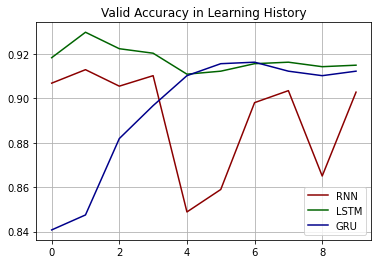

In [35]:
plt.plot(history1.history['val_accuracy'], label='RNN', c='darkred')
plt.plot(history2.history['val_accuracy'], label='LSTM', c='darkgreen')
plt.plot(history3.history['val_accuracy'], label='GRU', c='darkblue')
plt.title('Valid Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()